# Advanced Lab Version: Data Mining Techniques on Digits

This is a second, more complex version of the lab using a higher-dimensional dataset.

Focus areas:
- Visualization of high-dimensional data
- K-Means clustering with PCA projection
- Decision Trees (`gini` vs `entropy`) for multiclass classification
- Missing-data imputation and performance impact


## 1. Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

RANDOM_STATE = 42
sns.set_theme(style="whitegrid", context="notebook")


## 2. Load Open-Source Dataset (Digits)

The Digits dataset contains 8x8 grayscale images of handwritten digits (0-9).


In [2]:
digits = load_digits()

X = pd.DataFrame(digits.data, columns=[f"pixel_{i}" for i in range(digits.data.shape[1])])
y = pd.Series(digits.target, name="target")

df = X.copy()
df["target"] = y
df["target_name"] = y.astype(str)

print("Shape:", df.shape)
print("Number of classes:", len(np.unique(y)))
print("Class labels:", sorted(np.unique(y).tolist()))
df.head()


Shape: (1797, 66)
Number of classes: 10
Class labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,target,target_name
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,4


## 3. Quick EDA


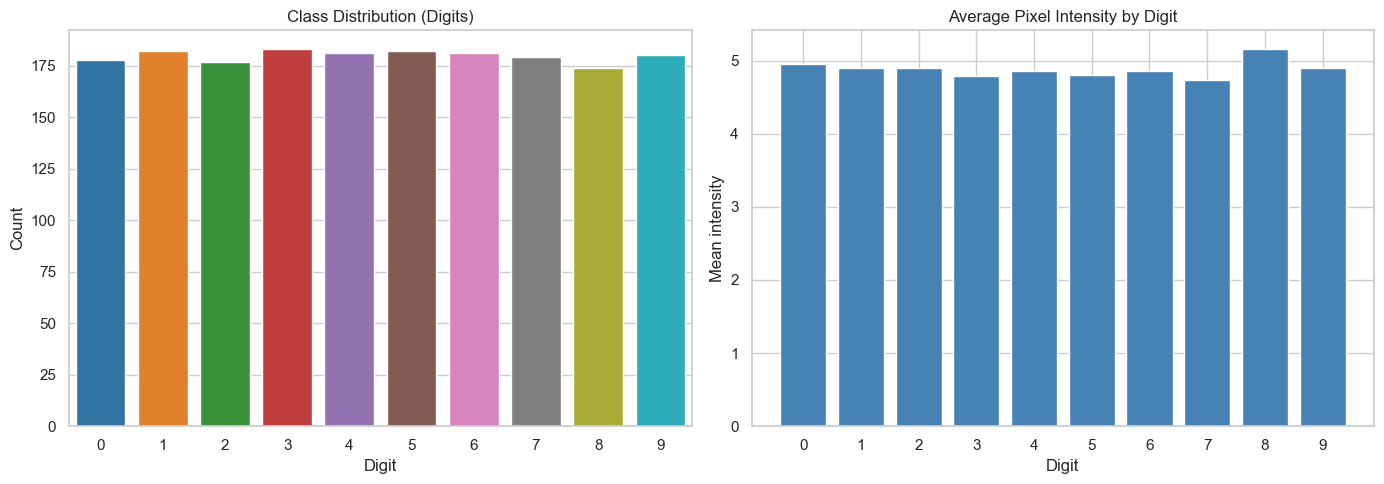

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
sns.countplot(data=df, x="target_name", hue="target_name", palette="tab10", ax=axes[0], legend=False)
axes[0].set_title("Class Distribution (Digits)")
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Count")

# Mean intensity by class
mean_intensity = df.groupby("target").mean(numeric_only=True).mean(axis=1)
axes[1].bar(mean_intensity.index.astype(str), mean_intensity.values, color="steelblue")
axes[1].set_title("Average Pixel Intensity by Digit")
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Mean intensity")

plt.tight_layout()
plt.show()


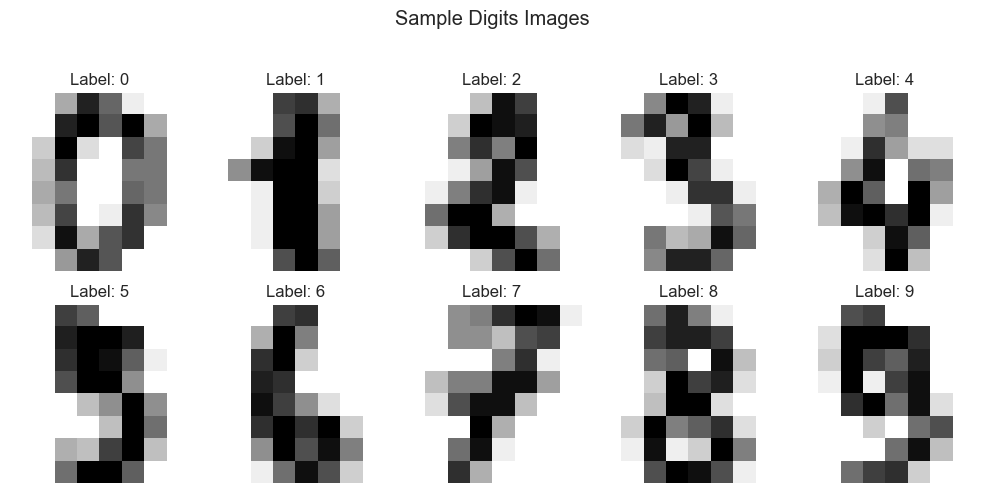

In [4]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(digits.images[i], cmap="gray_r")
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis("off")
plt.suptitle("Sample Digits Images", y=1.02)
plt.tight_layout()
plt.show()


## 4. Clustering Visualization (K-Means)


In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=20)
cluster_labels = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster sizes:")
print(cluster_counts.to_string())

cluster_vs_class = pd.crosstab(
    pd.Series(cluster_labels, name="cluster"),
    y,
    normalize="index",
).round(2)
cluster_vs_class


Cluster sizes:
0    188
1    178
2    181
3    161
4    434
5    264
6    108
7     76
8     30
9    177


target,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0.00,0.00,0.47,0.05,0.01,0.37,0.00,0.04,0.06,0.01
1,0.99,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
2,0.00,0.01,0.00,0.00,0.00,0.02,0.96,0.00,0.01,0.00
3,0.01,0.00,0.00,0.00,0.98,0.01,0.00,0.00,0.00,0.00
4,0.00,0.00,0.02,0.36,0.00,0.18,0.00,0.00,0.11,0.34
5,0.00,0.36,0.11,0.03,0.01,0.08,0.02,0.00,0.38,0.01
6,0.00,0.54,0.04,0.00,0.06,0.03,0.01,0.03,0.12,0.18
7,0.00,0.36,0.63,0.01,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.60,0.00,0.10


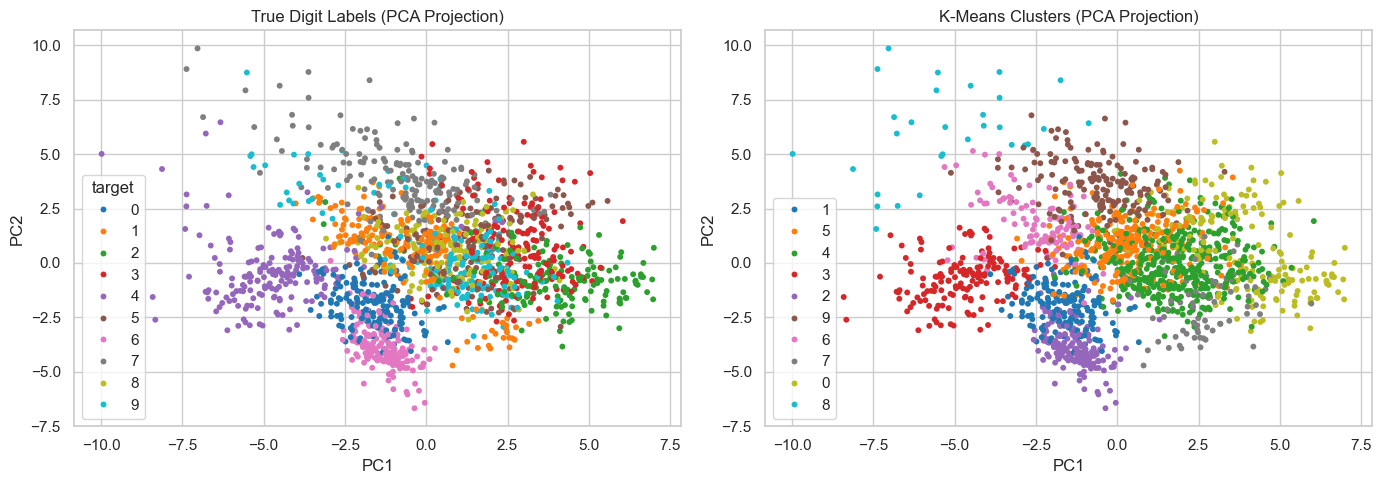

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y.astype(str), palette="tab10", s=18, linewidth=0, ax=axes[0]
)
axes[0].set_title("True Digit Labels (PCA Projection)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels.astype(str), palette="tab10", s=18, linewidth=0, ax=axes[1]
)
axes[1].set_title("K-Means Clusters (PCA Projection)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


## 5. Decision Trees: Gini vs Entropy


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

def train_and_eval(criterion, depth=12):
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=depth,
        random_state=RANDOM_STATE,
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return model, preds, acc

model_gini, preds_gini, acc_gini = train_and_eval("gini", depth=12)
model_entropy, preds_entropy, acc_entropy = train_and_eval("entropy", depth=12)

print(f"Gini accuracy:    {acc_gini:.3f}")
print(f"Entropy accuracy: {acc_entropy:.3f}")


Gini accuracy:    0.820
Entropy accuracy: 0.840


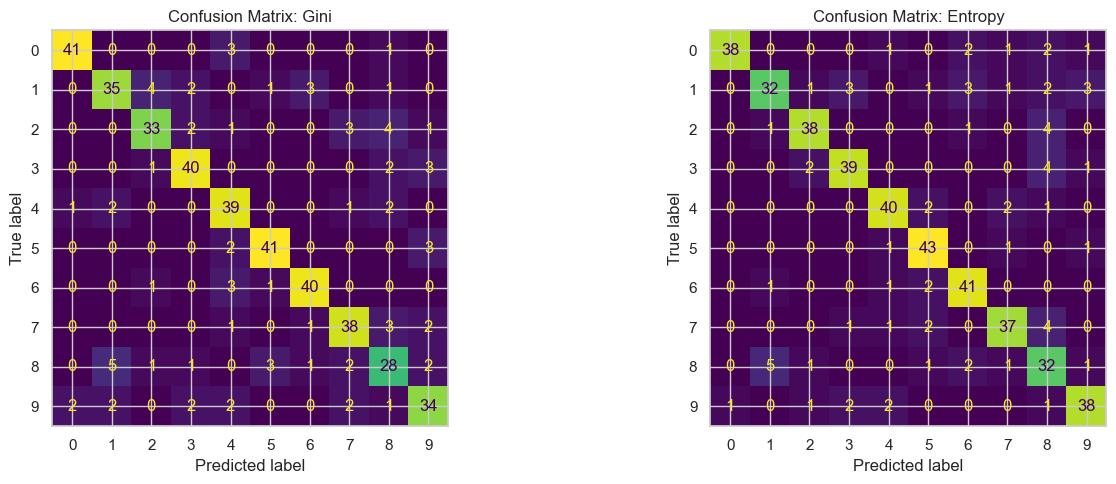

Classification report (Entropy):
              precision    recall  f1-score   support

           0       0.97      0.84      0.90        45
           1       0.82      0.70      0.75        46
           2       0.88      0.86      0.87        44
           3       0.87      0.85      0.86        46
           4       0.87      0.89      0.88        45
           5       0.84      0.93      0.89        46
           6       0.84      0.91      0.87        45
           7       0.86      0.82      0.84        45
           8       0.64      0.74      0.69        43
           9       0.84      0.84      0.84        45

    accuracy                           0.84       450
   macro avg       0.84      0.84      0.84       450
weighted avg       0.84      0.84      0.84       450



In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ConfusionMatrixDisplay(confusion_matrix(y_test, preds_gini)).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix: Gini")

ConfusionMatrixDisplay(confusion_matrix(y_test, preds_entropy)).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix: Entropy")

plt.tight_layout()
plt.show()

print("Classification report (Entropy):")
print(classification_report(y_test, preds_entropy, target_names=[str(x) for x in digits.target_names]))


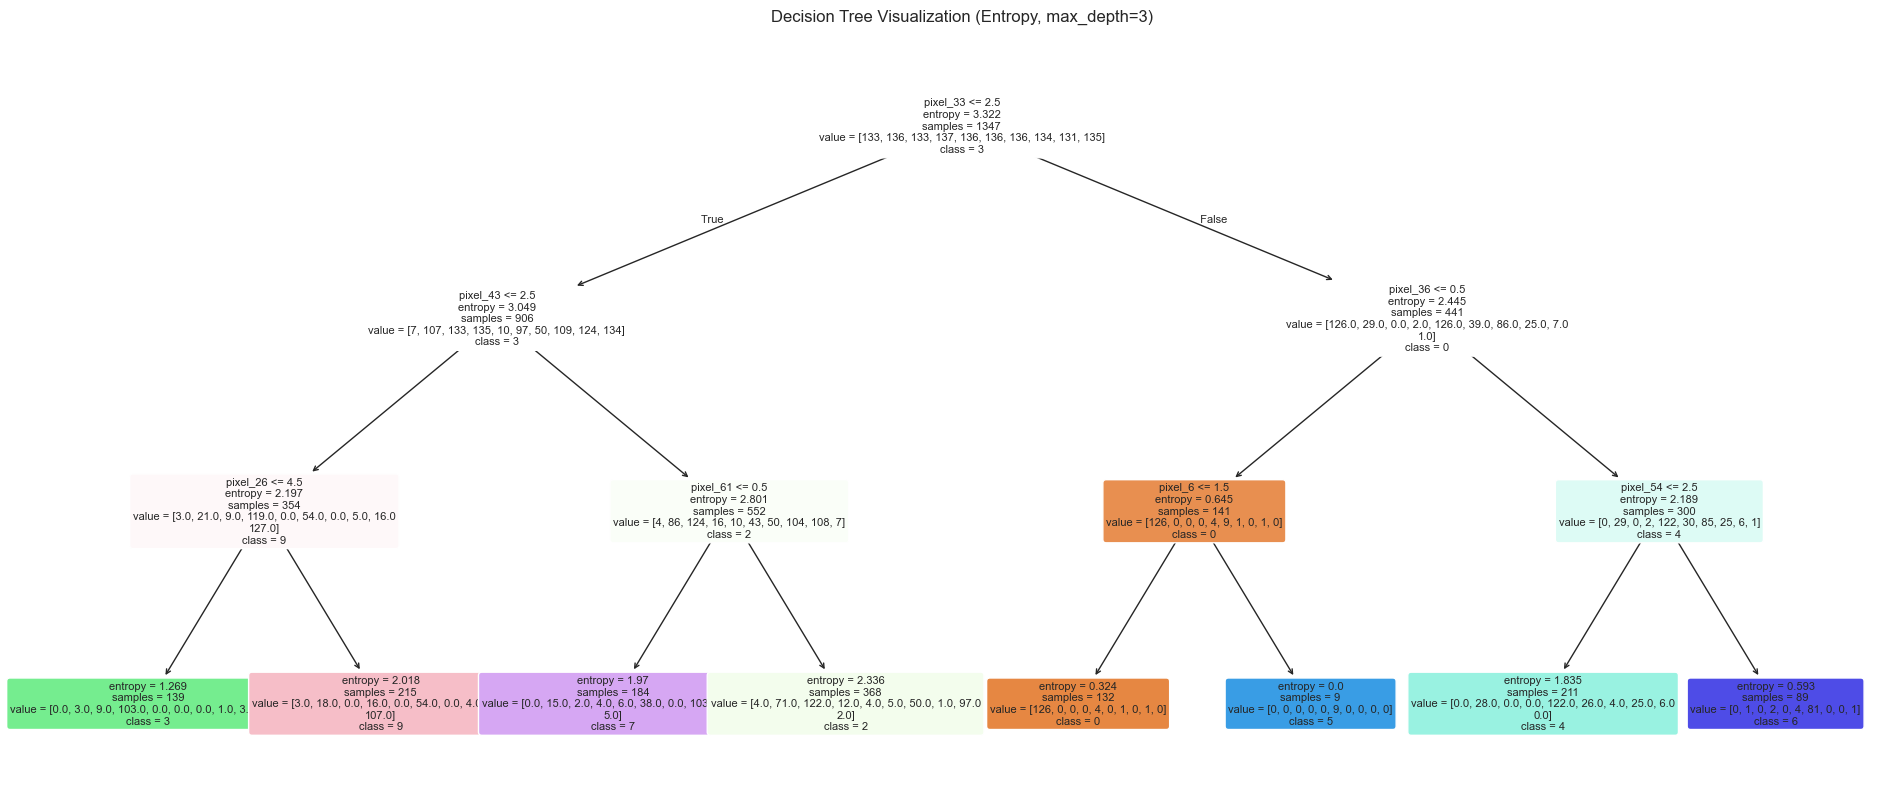

In [9]:
# Use a shallower tree only for visualization readability
model_entropy_shallow = DecisionTreeClassifier(
    criterion="entropy", max_depth=3, random_state=RANDOM_STATE
)
model_entropy_shallow.fit(X_train, y_train)

plt.figure(figsize=(24, 10))
plot_tree(
    model_entropy_shallow,
    feature_names=X.columns,
    class_names=[str(x) for x in digits.target_names],
    filled=True,
    rounded=True,
    fontsize=8,
)
plt.title("Decision Tree Visualization (Entropy, max_depth=3)")
plt.show()


## 6. Model Complexity and Overfitting


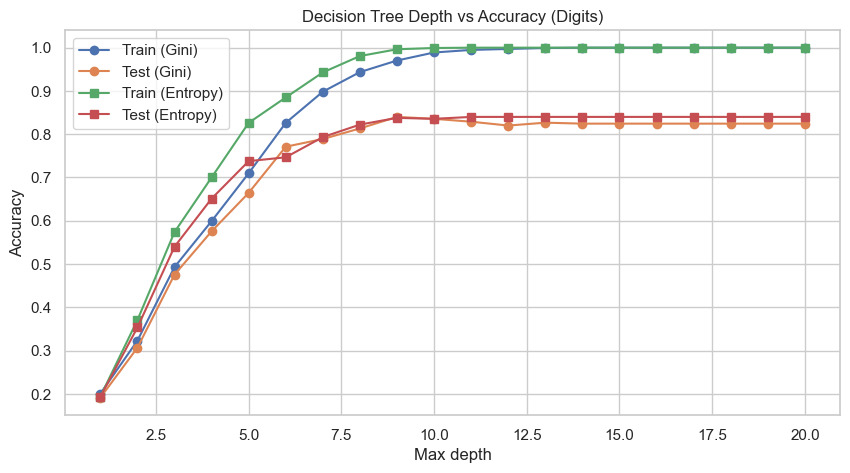

In [10]:
depths = range(1, 21)
train_scores_gini, test_scores_gini = [], []
train_scores_entropy, test_scores_entropy = [], []

for d in depths:
    m_g = DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=RANDOM_STATE)
    m_e = DecisionTreeClassifier(criterion="entropy", max_depth=d, random_state=RANDOM_STATE)

    m_g.fit(X_train, y_train)
    m_e.fit(X_train, y_train)

    train_scores_gini.append(m_g.score(X_train, y_train))
    test_scores_gini.append(m_g.score(X_test, y_test))

    train_scores_entropy.append(m_e.score(X_train, y_train))
    test_scores_entropy.append(m_e.score(X_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores_gini, marker="o", label="Train (Gini)")
plt.plot(depths, test_scores_gini, marker="o", label="Test (Gini)")
plt.plot(depths, train_scores_entropy, marker="s", label="Train (Entropy)")
plt.plot(depths, test_scores_entropy, marker="s", label="Test (Entropy)")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Depth vs Accuracy (Digits)")
plt.legend()
plt.show()


## 7. Feature Importance


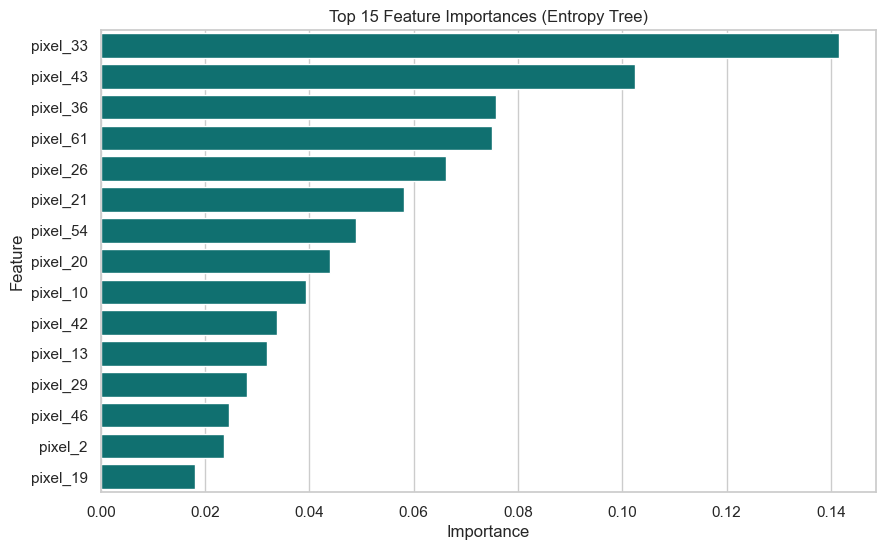

pixel_33    0.141556
pixel_43    0.102517
pixel_36    0.075727
pixel_61    0.075022
pixel_26    0.066137
pixel_21    0.058209
pixel_54    0.048858
pixel_20    0.043895
pixel_10    0.039434
pixel_42    0.033813
pixel_13    0.031862
pixel_29    0.027964
pixel_46    0.024501
pixel_2     0.023698
pixel_19    0.017985
dtype: float64

In [11]:
importance = pd.Series(model_entropy.feature_importances_, index=X.columns).sort_values(ascending=False)
top_n = 15

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.head(top_n).values, y=importance.head(top_n).index, color="teal")
plt.title(f"Top {top_n} Feature Importances (Entropy Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

importance.head(top_n)


## 8. Missing Data and Imputation Techniques


In [12]:
# Simulate missing values in 10% of feature cells
missing_rate = 0.10
rng = np.random.default_rng(RANDOM_STATE)

X_missing = X.copy()
mask = rng.random(X_missing.shape) < missing_rate
X_missing = X_missing.mask(mask)

missing_total = int(X_missing.isna().sum().sum())
missing_pct = 100 * missing_total / X_missing.size
print(f"Missing cells: {missing_total} ({missing_pct:.1f}%)")

X_missing.isna().mean().sort_values(ascending=False).head(10)


Missing cells: 11362 (9.9%)


pixel_3     0.116861
pixel_45    0.110740
pixel_28    0.110740
pixel_0     0.110184
pixel_23    0.110184
pixel_6     0.108514
pixel_36    0.107401
pixel_20    0.106288
pixel_59    0.105732
pixel_56    0.104619
dtype: float64

In [13]:
X_train_miss, X_test_miss, y_train_miss, y_test_miss = train_test_split(
    X_missing, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

imputers = {
    "mean": SimpleImputer(strategy="mean"),
    "median": SimpleImputer(strategy="median"),
    "most_frequent": SimpleImputer(strategy="most_frequent"),
    "knn": KNNImputer(n_neighbors=5),
}

rows = []
for name, imputer in imputers.items():
    X_train_imp = imputer.fit_transform(X_train_miss)
    X_test_imp = imputer.transform(X_test_miss)

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=12, random_state=RANDOM_STATE)
    clf.fit(X_train_imp, y_train_miss)
    preds = clf.predict(X_test_imp)

    rows.append(
        {
            "imputer": name,
            "accuracy": accuracy_score(y_test_miss, preds),
            "remaining_missing_train": int(np.isnan(X_train_imp).sum()),
            "remaining_missing_test": int(np.isnan(X_test_imp).sum()),
        }
    )

imputation_results = pd.DataFrame(rows).sort_values("accuracy", ascending=False)
imputation_results


,imputer,accuracy,remaining_missing_train,remaining_missing_test
3,knn,0.846667,0,0
1,median,0.768889,0,0
0,mean,0.755556,0,0
2,most_frequent,0.724444,0,0


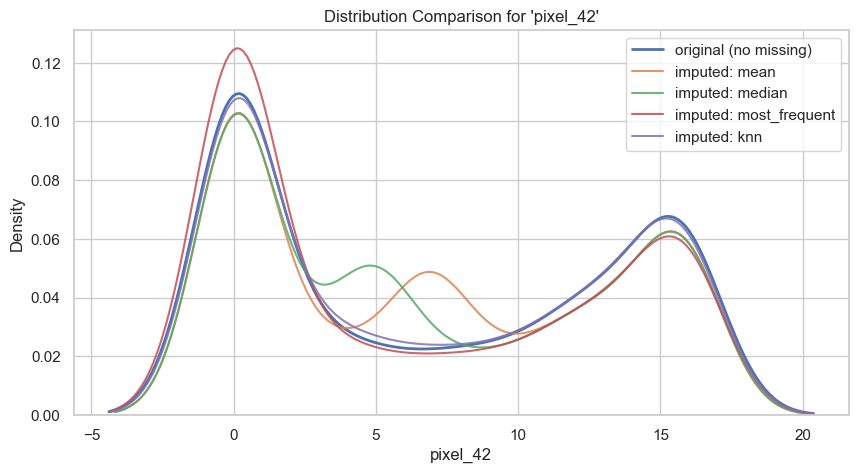

In [14]:
feature = "pixel_42"
feature_idx = X.columns.get_loc(feature)

plt.figure(figsize=(10, 5))
sns.kdeplot(X[feature], label="original (no missing)", linewidth=2)

for name, imputer in imputers.items():
    X_imp_full = imputer.fit_transform(X_missing)
    sns.kdeplot(X_imp_full[:, feature_idx], label=f"imputed: {name}", alpha=0.85)

plt.title(f"Distribution Comparison for '{feature}'")
plt.xlabel(feature)
plt.ylabel("Density")
plt.legend()
plt.show()


## 9. Variant Tasks for 10 Students (Advanced)

### Variant 1
1. Change `n_clusters` from 10 to 8 and 12.
2. Compare cluster sizes and PCA cluster maps.
3. Explain which setting gives more interpretable groups.

### Variant 2
1. Run K-Means without scaling and with scaling.
2. Compare PCA plots and cluster compactness visually.
3. Explain why scaling matters for pixel features.

### Variant 3
1. Train trees with `max_depth=6`, `12`, and `18` using `gini`.
2. Compare train/test accuracy and overfitting gap.
3. Recommend a depth for this dataset.

### Variant 4
1. Compare `gini` vs `entropy` at a fixed depth.
2. Compare confusion matrices for the two criteria.
3. Identify which digit pairs are most confused.

### Variant 5
1. Add macro-averaged precision/recall/F1 to criterion comparison.
2. Summarize which criterion is better overall.
3. Explain whether the difference is practically meaningful.

### Variant 6
1. Increase missingness from `10%` to `20%`.
2. Compare imputer rankings by test accuracy.
3. Explain which method is more stable as missingness grows.

### Variant 7
1. Compare `KNNImputer` with `n_neighbors=3`, `5`, and `9`.
2. Report accuracy and runtime tradeoffs.
3. Pick the best setting and justify it.

### Variant 8
1. Pick two pixel features and compare original vs imputed distributions.
2. Identify which imputer distorts each distribution least.
3. Explain how this might affect model behavior.

### Variant 9
1. Retrain after keeping only top-15 important features.
2. Compare accuracy vs the full-feature model.
3. Discuss interpretability vs performance tradeoff.

### Variant 10
1. Build a final summary table for clustering, tree tuning, and imputation.
2. Propose the best end-to-end pipeline for Digits.
3. Write a short executive summary (6-8 sentences).
